In [1]:
import pandas as pd
import json
import csv 
import glob
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from operator import itemgetter
import random

In [ ]:
!pip install pyspark

In [ ]:
import pyspark
sc = pyspark.SparkContext(appName="mySparkApp")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
directory= "/content/drive/MyDrive/BigData"
os.chdir(directory)

In [ ]:
# Funzione profile che mi corregge le incongruenze di nomi dei profili delle VeronaCard

def profile(data):  
    count= data.count()
    dw= data.take(count)

    for i in range(len(dw)):
        x = dw[i]
        if(dw[i][8].startswith('vrcard-24') or dw[i][8].startswith('vrcard2-24') ):
            dw[i][8]='24 Ore'
        elif(dw[i][8].startswith('vrcard-48') or dw[i][8].startswith('vrcard2-48')):
            dw[i][8]='48 Ore'
        elif(dw[i][8].startswith('vrcard-72') or dw[i][8].startswith('vrcard2-72')):
            dw[i][8]='72 Ore'

    data_vr = sc.parallelize(dw)
    return data_vr

***

# **1. Interrogazioni dati delle strisciate delle VeronaCard**


nome campo | significato
--- | --- 
Data | Data di ingresso
Ora | Ora ingresso 
POI | Point of interest (ovvero la struttura che viene visitata)
device | Codice del dispositivo su cui è stata fatta la strisciata 
serialVC | Seriale VeronaCard
dataActivation | Data di attivazione
in | number
number | number
profile | Tipo di VeronaCard (24-ore, 48-ore, ecc...) 



\
Quelli che interessano a noi saranno:


Data | Ora | POI | serialVC | profile
--- | --- | --- | --- | --- | 
'30-12-14' | '18:40:38' | 'Tomba Giulietta' | '049B31523F3880' | '24 Ore' 

\
Quindi i campi:

```
x[0], x[1], x[2], x[4], x[8]
```


In [ ]:
filename= "/content/drive/MyDrive/BigData/dati.csv"
fileRdd = sc.textFile(filename)

In [ ]:
fileRdd.take(5)

\
***

## **Pulizia dei dati**

In [ ]:
data= fileRdd.map(lambda row : row.split(","))

In [ ]:
data.take(2)

[['30-12-14',
  '18:40:38',
  'Tomba Giulietta',
  '40',
  '049B31523F3880',
  '30-12-14',
  'in',
  '1',
  '24 Ore'],
 ['30-12-14',
  '18:40:36',
  'Tomba Giulietta',
  '40',
  '049B26523F3880',
  '30-12-14',
  'in',
  '1',
  '24 Ore']]

In [ ]:
data_2 = data.filter(lambda x: (x[0].endswith('16') or x[0].endswith('18') or x[0].endswith('19') or x[0].endswith('20') ))

In [ ]:
data_vr = profile(data_2)

In [ ]:
data_vr = data_vr.map(lambda x: (datetime.strptime(x[0][0:-2] + '20' + x[0][-2:8], "%d-%m-%Y")\
                                 .strftime("%Y-%m-%d"), x[1], x[2], x[4], x[8]))
data_vr.persist()
data_vr.take(3)

[('2016-12-30', '18:53:37', 'Casa Giulietta', '04A3043A9C4C84', '24 Ore'),
 ('2016-12-30', '18:53:36', 'Casa Giulietta', '04F2013A9C4C84', '24 Ore'),
 ('2016-12-30', '18:44:26', 'Casa Giulietta', '0474C6429C4C80', '24 Ore')]

In [ ]:
d_error = data.filter(lambda x: x[4] == '04AB1DE2185084')
d_error.first()

['30-12-18',
 '18:32:51',
 'Casa Giulietta',
 '28',
 '04AB1DE2185084',
 '30-12-18',
 'in',
 '1',
 'vrcard-24-2019']

In [ ]:
d_correct = data_vr.filter(lambda x: x[3] == '04AB1DE2185084')
d_correct.first()

('2018-12-30', '18:32:51', 'Casa Giulietta', '04AB1DE2185084', '24 Ore')

\
***

## **Query 1**
Trovare il giorno con più accessi alle strutture di interesse e quello con meno e analizzare per il gorno con più accessi il numero di accessi ai POI durante le varie ore del giorno. 


**1. *Trovare il giorno con più accessi alle strutture di interesse e quello con meno.***

In [ ]:
day = data_vr.map(lambda x: (x[0],1)).reduceByKey(lambda a,b: a+b)
day_max_visit = day.max(lambda x:x[1])
day_min_visit = day.min(lambda x:x[1])

print("Giorno con più accessi: {} \nNumero di accessi: {} \n".format(day_max_visit[0], day_max_visit[1]))

print("Giorno con meno accessi: {} \nNumero di accessi: {}".format(day_min_visit[0], day_min_visit[1]))


Giorno con più accessi: 2016-10-30 
Numero di accessi: 8258 

Giorno con meno accessi: 2020-11-02 
Numero di accessi: 2


 **2. *Analizzare, per il giorno con massimi accessi, il numero di accessi durante le varie ore del giorno*.** 

In [ ]:
daily_visitors_max = data_vr.filter(lambda x: x[0] == day_max_visit[0] ) \
                    .map(lambda x: (datetime.strptime(x[1], '%H:%M:%S').time().hour ,1))\
                    .reduceByKey(lambda a,b: a+b)\
                    
dv_max = daily_visitors_max.collect()              
dv_max= sorted(dv_max)

In [ ]:
dv_max

[(8, 54),
 (9, 320),
 (10, 776),
 (11, 964),
 (12, 890),
 (13, 864),
 (14, 1104),
 (15, 1318),
 (16, 1074),
 (17, 730),
 (18, 164)]

Text(15, 15, '8')

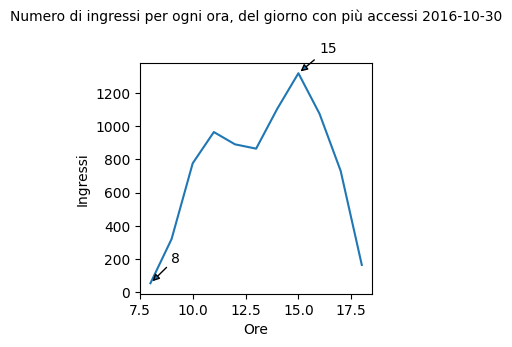

In [ ]:
visit_number_max = [ x[1] for x in dv_max]
hour_max = [x[0] for x in dv_max]
n_access_max = daily_visitors_max.max(lambda x:x[1])
n_access_min = daily_visitors_max.min(lambda x:x[1])

xmax= n_access_max[0]
ymax= n_access_max[1]

xmin= n_access_min[0]
ymin= n_access_min[1]


fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
ax.set_title('Numero di ingressi per ogni ora, del giorno con più accessi {}'.format(day_max_visit[0]), pad=30, fontsize=10)
ax.set(xlabel='Ore', ylabel='Ingressi')
ax.plot(hour_max, visit_number_max)
ax.annotate(str(xmax), (xmax, ymax), xytext=(15, 15), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate(str(xmin), (xmin, ymin), xytext=(15, 15), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))




\
***

## **Query 2**
Verificare i valori di concentrazione di visitatori nei vari poi prendendo in considerazione prima tutti i giorni registrati e successivamente solo il giorno con maggiori accessi.

In [ ]:
def access(poi, visit):
    j=0
    list_visit= []
    n= len(poi)
    for i in range(n):
        try:
            visit[j][0]
        except IndexError:
            if len(poi) > len(visit):
                list_visit.extend(n*[0])
            
            return list_visit
            
        if(poi[i] == visit[j][0]):
            list_visit.append(visit[j][1])
            j+=1
        else:
            list_visit.append(0)
        n-=1
    return list_visit

In [ ]:
def percent(list_):
    list_percent=[]
    sum_ = sum(list_)
    for i in list_:
        list_percent.append(i/sum_)
    return list_percent

***

In [ ]:
poi = data_vr.map(lambda x: x[2]).distinct().collect()
poi = sorted(poi)
poi

['Arena',
 'Casa Giulietta',
 'Castelvecchio',
 'Duomo',
 'Giardino Giusti',
 'Museo Conte',
 'Museo Lapidario',
 'Museo Miniscalchi',
 'Museo Radio',
 'Museo Storia',
 'Palazzo della Ragione',
 'San Fermo',
 'San Zeno',
 'Santa Anastasia',
 'Sighseeing',
 'Teatro Romano',
 'Tomba Giulietta',
 'Torre Lamberti',
 'Verona Tour']

### **1.** Numero di accessi considerando tutti i giorni registrati

In [ ]:
d_visit = data_vr.map(lambda x: (x[2], 1))\
            .reduceByKey(lambda a,b: a+b)\
            .sortBy(lambda x: x[0]) \
            .collect() 

In [ ]:
day_tot= data_vr.map(lambda x: x[0]).distinct().count()
l_visit =[]
for p in d_visit:
  l_visit.append((p[0], int(p[1]/day_tot)))  

In [ ]:
l_visit

[('Arena', 371),
 ('Casa Giulietta', 325),
 ('Castelvecchio', 239),
 ('Duomo', 177),
 ('Giardino Giusti', 28),
 ('Museo Conte', 0),
 ('Museo Lapidario', 34),
 ('Museo Miniscalchi', 0),
 ('Museo Radio', 0),
 ('Museo Storia', 13),
 ('Palazzo della Ragione', 98),
 ('San Fermo', 78),
 ('San Zeno', 72),
 ('Santa Anastasia', 195),
 ('Sighseeing', 0),
 ('Teatro Romano', 133),
 ('Tomba Giulietta', 79),
 ('Torre Lamberti', 250),
 ('Verona Tour', 0)]

In [ ]:
list_all_visit = access(poi, l_visit)
list_all_visit

[371, 325, 239, 177, 28, 0, 34, 0, 0, 13, 98, 78, 72, 195, 0, 133, 79, 250, 0]

### **2.** Numero di accessi nel giorno con maggiori visite

In [ ]:
l_max_visit = data_vr.filter(lambda x: x[0] == day_max_visit[0]) \
                .map(lambda x: (x[2], 1)) \
                .reduceByKey(lambda a,b: a+b) \
                .sortBy(lambda x: x[0]) \
                .collect()

In [ ]:
l_max_visit

[('Arena', 1456),
 ('Casa Giulietta', 1268),
 ('Castelvecchio', 890),
 ('Duomo', 448),
 ('Giardino Giusti', 130),
 ('Museo Lapidario', 198),
 ('Museo Radio', 4),
 ('Museo Storia', 44),
 ('Palazzo della Ragione', 594),
 ('San Fermo', 212),
 ('San Zeno', 176),
 ('Santa Anastasia', 520),
 ('Teatro Romano', 816),
 ('Tomba Giulietta', 462),
 ('Torre Lamberti', 1040)]

In [ ]:
list_max_visit = access( poi, l_max_visit )
print(list_max_visit)

[1456, 1268, 890, 448, 130, 0, 198, 0, 4, 44, 594, 212, 176, 520, 0, 816, 462, 1040, 0]


### **Plot**

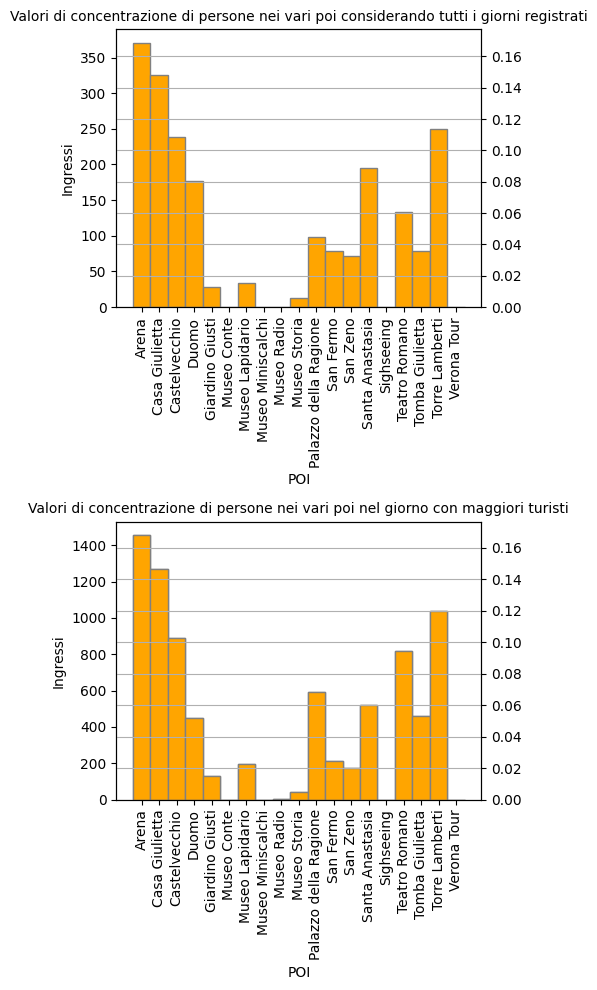

In [ ]:
# Plot accessi ai vari POI su tutti i giorni
xs = poi
ys = list_all_visit
l = percent(list_all_visit)

fig, ax = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(5)
ax[0].set_title('Valori di concentrazione di persone nei vari poi considerando tutti i giorni registrati', fontsize=10)
ax[0].set(xlabel='POI', ylabel='Ingressi')
ax[0].bar(xs, ys,
        1,             # la larghezza delle barre
        ec = "grey",   # qualcuno ha suggerito che il colore di default blu è deprimente,
                         # perciò mettiamo il verde
        fc = "orange",
        align='center')  # alline le barre sull'xtick


ax[0].tick_params(axis='x', labelrotation = 90)
ax2= ax[0].twinx()
ax2.set_ylim(min(l), max(l));

plt.grid()
fig.tight_layout()


# Plot accessi ai vari POI del giorno con massime visite
xs = poi
ys = list_max_visit
l = percent(list_max_visit)

ax[1].set_title('Valori di concentrazione di persone nei vari poi nel giorno con maggiori turisti',  fontsize=10)
ax[1].set(xlabel='POI', ylabel='Ingressi')
ax[1].bar(xs, ys,
        1,             # la larghezza delle barre
        ec = "grey",   # qualcuno ha suggerito che il colore di default blu è deprimente,
                         # perciò mettiamo il verde
        fc = "orange",
        align='center')  # alline le barre sull'xtick

ax[1].bar(xs, ys,
        1,             # la larghezza delle barre
        ec = "grey",   # qualcuno ha suggerito che il colore di default blu è deprimente,
                         # perciò mettiamo il verde
        fc = "orange",
        align='center')  # alline le barre sull'xtick


ax[1].tick_params(axis='x', labelrotation = 90)
ax2= ax[1].twinx()
ax2.set_ylim(min(l), max(l));

fig.tight_layout()
plt.grid()
plt.show()


\
***

# 2. **Interrogazioni con dati meteorologici**

In [ ]:
filename= "/content/drive/MyDrive/BigData/meteo.csv"
fileRdd_weather = sc.textFile(filename)
fileRdd_weather.take(3)

['data,ora,t,ur,pr,wind,wind_dir,rain,dp,idstazione',
 '2016-02-08,11.54,10.7,82,1015.5,4.26,ESE,10.30,7.8,243',
 '2016-02-08,11.50,9.0,97,1015.5,7.97,SSW,19.80,8.5,351']

Le istanze si presenteranno con i seguenti campi:

data |ora | t | ur | pr | wind | wind_dir | rain | dp | idstazione 
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
2016-02-08 | 11.54 | 10.7 | 82 | 1015.5 | 4.26 | ESE | 10.30 | 7.8 | 243

\
Quelli che interessano a noi saranno:

data |ora | t | rain 
--- | --- | --- | --- | 
2016-02-08 | 11.54 | 10.7 |  10.30









\
***

## **Pulizia dati**
1. Iniziamo ad eliminare la prima riga, rappresentate i nomi dei vari campi
2. Rendiamo l'ora nel formato giusto, ovvero HH:MM
3. Convertiamo in float i dati relativi alla temperatura e alla precipitazione
3. Selezioniamo le righe che ci interessano
4. Filtriamo le ore in modo da selezionare solamente quelle rilevanti per gli accessi delle VeronaCard

In [ ]:
# funzione per rendere l'ora nel formato: HH:MM
def error(x):
  if(x.endswith('.')):
    return x[:2]  + ':' + x[3] +'0'
  return x

In [ ]:
index = fileRdd_weather.first()

data_weather = fileRdd_weather.filter(lambda row: row != index)\
                .map(lambda row : row.split(","))\
                .map(lambda x: (x[0], x[1][:2] + ':' + x[1][3:], float(x[2]), float(x[7])))\
                .filter(lambda x: (x[1] > '08:00') and (x[1] < '18:00') and (x[2] < 50 and x[2] > -20) and (x[3]>0 and x[3]<60))\
                .map(lambda x: (x[0], error(x[1]), x[2], x[3] ))
                #x[0] : data , x[1]: ora, x[2]: temp, x[3] : rain
data_weather.persist()
data_weather.take(3)

[('2016-02-08', '11:54', 10.7, 10.3),
 ('2016-02-08', '11:50', 9.0, 19.8),
 ('2016-02-08', '11:53', 8.7, 10.2)]

## Funzioni

In [ ]:
def mean_x(x):
    list_=[]
    for i in x:
        n= len(i[1])
        list_.append((i[0],sum(i[1])/n))
        
    return list_

In [ ]:
def hour_x(list_):
    ho = []
    x = []
    for i in list_:
        ho.append(i[0])
        x.append(i[1])
    return ho, x

\
***

## ***Query Pioggia***

1. Trovare il giorno con più e meno accessi e verificare i livelli di pioggia per quei giorni.
1. Analizzare la concentrazione di visitatori nei vari POI in un giorno di pioggia  [ t>6 ] e non [t<4]



\

- pioggia debole (1 – 2 mm/h) \
- pioggia leggera (2 – 4 mm/h) \
- pioggia moderata (4 – 6 mm/h) \
- pioggia forte (> 6 mm/h) 

\


Seleziono i seguenti campi:

data | ora | rain |
--- | --- | --- |
'2016-02-08' | '11:54' | 10.3



In [ ]:
data_rain = data_weather.map(lambda x: (x[0], x[1] ,x[3]))

### **Query 1**

Trovare i giorni con più e meno accessi e verificare i livelli di ***pioggia*** per quei giorni.

In [ ]:
print(day_max_visit)
print(day_min_visit)

('2016-10-30', 8258)
('2020-11-02', 2)


In [ ]:
rain_day_max = data_rain.filter(lambda x: x[0] == day_max_visit[0])
rain_day_min = data_rain.filter(lambda x: x[0] == day_min_visit[0])

In [ ]:
rain_day_max = rain_day_max.map(lambda x: (x[1][:2], x[2])).groupByKey()\
          .map(lambda x : (x[0], list(x[1])))\
          .collect()
rain_day_min = rain_day_min.map(lambda x: (x[1][:2], x[2])).groupByKey() \
          .map(lambda x : (x[0], list(x[1])))\
          .collect()

# calcolo il valore medio per ogni ora del giorno          
lrain_mean_max=  mean_x(rain_day_max)
lrain_mean_min= mean_x(rain_day_min)

# ordino con orari crescenti
lrain_mean_max= sorted(lrain_mean_max, key=itemgetter(0))
lrain_mean_min= sorted(lrain_mean_min, key=itemgetter(0))

```
>> rain_day_max

[('19', [10.3, 7.8, 9.5,...]), 
 ('15', [0.3, 0.3, 0.3,... ]) 
 ... ]
```


In [ ]:
lrain_mean_max

[('08', 0.5693181818181822),
 ('09', 0.5599315068493156),
 ('10', 0.5477272727272732),
 ('11', 0.5477272727272732),
 ('12', 0.5581699346405233),
 ('13', 0.5475000000000004),
 ('14', 0.5506756756756761),
 ('15', 0.5532467532467538),
 ('16', 0.5490625000000006),
 ('17', 0.5525641025641032)]

In [ ]:
time_max, rain_max = hour_x(lrain_mean_max)
time_min, rain_min = hour_x(lrain_mean_min)

### **Plot**
Vediamo dai grafici seguenti che c'è una differenza riguardo ai valori di precipitazione:
- Nel primo grafico, i valori vanno da un range di (0.012, 0.018) , quindi molto basso
- Nel secondo, i valori vanno da un range di (2.70, 3.10) , quindi significativamente più alto


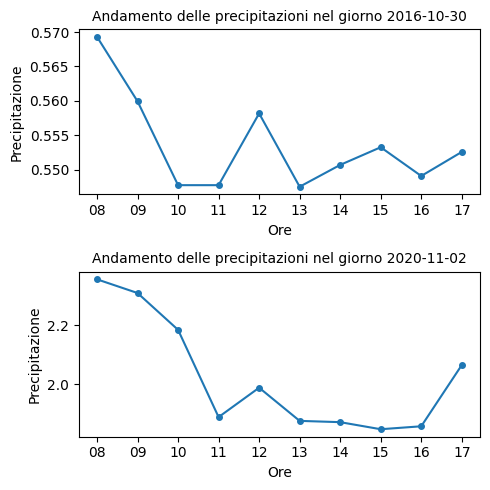

In [ ]:
fig, ax = plt.subplots(2)
fig.set_figheight(5)
fig.set_figwidth(5)
ax[0].set_title('Andamento delle precipitazioni nel giorno {}'.format(day_max_visit[0]), fontsize=10)
ax[0].set(xlabel='Ore', ylabel='Precipitazione')
ax[0].plot(time_max, rain_max, 'o', ls='-', ms=4)



ax[1].set_title('Andamento delle precipitazioni nel giorno {}'.format(day_min_visit[0]), fontsize=10)
ax[1].set(xlabel='Ore', ylabel='Precipitazione')
ax[1].plot(time_min, rain_min,  'o', ls='-', ms=4 )

fig.tight_layout()
plt.show()


### **Query 2**
Analizzare la concentrazione di visitatori nei vari POI in un giorno di pioggia forte  **[ p>6 ]** e con pioggia debole **[p<4]** \

In [ ]:
m_rain = data_rain.map(lambda x: (x[0], x[2]))\
          .groupByKey()\
          .map(lambda x : (x[0], list(x[1])))\
          .collect()

```
>> m_rain

[('2016-01-11', [0.3, 2.8, 0.5,...]), 
 ('2019-05-16', [0.3, 0.3, 0.3,... ]) 
 ... ]
```


In [ ]:
lista_mean_rain=  mean_x(m_rain)
lista_mean_rain= sorted(lista_mean_rain, key=itemgetter(0))

Ottengo ***list_mean_rain*** così costruita:
```
>> list_mean_rain

[('2016-01-11', 9.715892923998556),
 ('2016-01-18', 8.354323374340956),
 ... ]
```

In [ ]:
# filtro i giorni di pioggia
lista_day_rain = []
lista_day_no_rain = []
for x in lista_mean_rain:
  if(x[1] > 15):
    lista_day_rain.append(x[0])
  elif (x[1] < 5):
    lista_day_no_rain.append(x[0])

In [ ]:
# numero di giorni di pioggia forte
day_rain=len(set(lista_day_rain))
print(day_rain)

# numero di giorni con pioggia debole
day_no_rain= len(set(lista_day_no_rain))
print(day_no_rain)

89
1924


In [ ]:
print("Giorni con pioggia debole: {} \n".format(lista_day_no_rain))

print("Giorni con pioggia forte: {}".format(lista_day_rain))


Giorni con pioggia debole: ['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11', '2014-01-12', '2014-01-13', '2014-01-15', '2014-01-16', '2014-01-20', '2014-01-21', '2014-01-22', '2014-01-23', '2014-01-24', '2014-01-25', '2014-01-26', '2014-01-27', '2014-01-29', '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08', '2014-02-11', '2014-02-12', '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16', '2014-02-18', '2014-02-20', '2014-02-21', '2014-02-23', '2014-02-24', '2014-02-25', '2014-02-27', '2014-02-28', '2014-03-03', '2014-03-06', '2014-03-07', '2014-03-08', '2014-03-09', '2014-03-10', '2014-03-11', '2014-03-12', '2014-03-14', '2014-03-15', '2014-03-16', '2014-03-17', '2014-03-18', '2014-03-19', '2014-03-20', '2014-03-21', '2014-03-22', '2014-03-24', '2014-03-25', '2014-03-26', '2014-03-28', '2014-03-29', '2014-03-30', '2014-04-01', '2014-04-02', '2014-04-03', '2014-04-05', '2014-04-06', '2014-04-07', '2014-

### **Query 2 - Giorni di pioggia forte**

In [ ]:
visit_rain= data_vr.filter(lambda x: x[0] in lista_day_rain)\
              .map(lambda x: (x[2], 1))\
              .reduceByKey(lambda a,b: a+b)\
              .sortBy(lambda x: x[0])\
              .collect()

In [ ]:
l_visit =[]
for p in visit_rain:
  l_visit.append((p[0], int(p[1]/day_rain)))      
      

In [ ]:
l_visit

[('Arena', 100),
 ('Casa Giulietta', 90),
 ('Castelvecchio', 72),
 ('Duomo', 48),
 ('Giardino Giusti', 6),
 ('Museo Conte', 0),
 ('Museo Lapidario', 9),
 ('Museo Miniscalchi', 0),
 ('Museo Radio', 0),
 ('Museo Storia', 3),
 ('Palazzo della Ragione', 29),
 ('San Fermo', 22),
 ('San Zeno', 20),
 ('Santa Anastasia', 53),
 ('Teatro Romano', 37),
 ('Tomba Giulietta', 21),
 ('Torre Lamberti', 73),
 ('Verona Tour', 0)]

In [ ]:
list_rain = access(poi, l_visit)
list_rain

[100, 90, 72, 48, 6, 0, 9, 0, 0, 3, 29, 22, 20, 53, 0, 37, 21, 73, 0]

### **Query 2 - Giorni di pioggia leggera**

In [ ]:
day_vr_no_rain= data_vr.filter(lambda x: x[0] in lista_day_no_rain)\
                .map(lambda x: (x[2], 1))\
                .reduceByKey(lambda a,b: a+b)\
                .sortBy(lambda x: x[0])\
                .collect()
l_visit =[]
for p in day_vr_no_rain:
  l_visit.append((p[0], int(p[1]/day_no_rain)))    

l_visit

[('Arena', 154),
 ('Casa Giulietta', 133),
 ('Castelvecchio', 97),
 ('Duomo', 72),
 ('Giardino Giusti', 11),
 ('Museo Conte', 0),
 ('Museo Lapidario', 14),
 ('Museo Miniscalchi', 0),
 ('Museo Radio', 0),
 ('Museo Storia', 5),
 ('Palazzo della Ragione', 39),
 ('San Fermo', 32),
 ('San Zeno', 29),
 ('Santa Anastasia', 79),
 ('Teatro Romano', 54),
 ('Tomba Giulietta', 33),
 ('Torre Lamberti', 102),
 ('Verona Tour', 0)]

In [ ]:
list_no_rain = access(poi, l_visit)
list_no_rain

[154, 133, 97, 72, 11, 0, 14, 0, 0, 5, 39, 32, 29, 79, 0, 54, 33, 102, 0]

### **Plot**

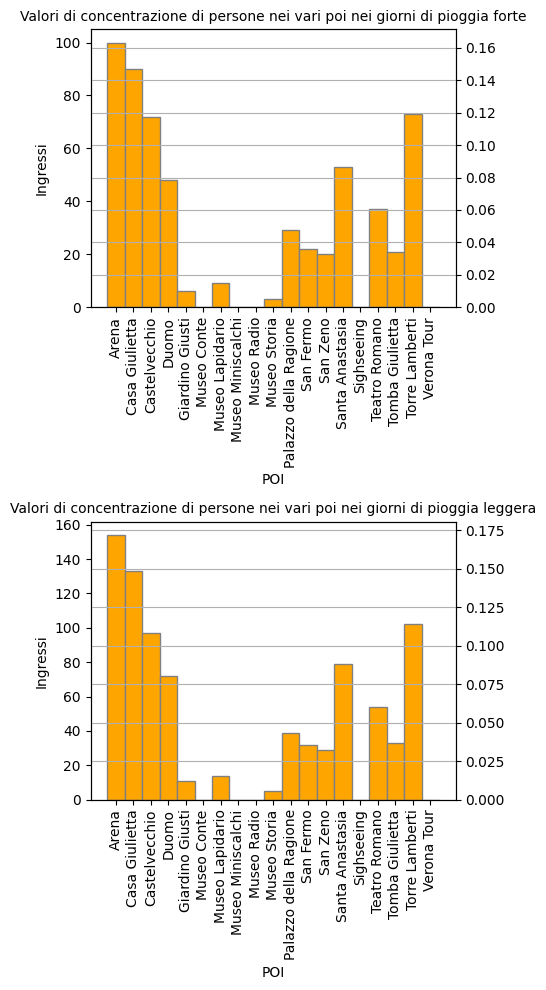

In [ ]:
xs = poi
ys = list_rain
l = percent(list_rain)

fig, ax = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(5)
ax[0].set_title('Valori di concentrazione di persone nei vari poi nei giorni di pioggia forte', fontsize=10)
ax[0].set(xlabel='POI', ylabel='Ingressi')
ax[0].bar(xs, ys,
        1,             # la larghezza delle barre
        ec = "grey",   
        fc = "orange",
        align='center')  # alline le barre sull'xtick


ax[0].tick_params(axis='x', labelrotation = 90)
ax2= ax[0].twinx()
ax2.set_ylim(min(l), max(l));

plt.grid()
fig.tight_layout()
xs1 = poi
ys1 = list_no_rain
l1 = percent(list_no_rain)

ax[1].set_title('Valori di concentrazione di persone nei vari poi nei giorni di pioggia leggera',fontsize=10)
ax[1].set(xlabel='POI', ylabel='Ingressi')
ax[1].bar(xs1, ys1,
        1,             # la larghezza delle barre
        ec = "grey",   
        fc = "orange",
        align='center')  # alline le barre sull'xtick


ax[1].tick_params(axis='x', labelrotation = 90)
ax2= ax[1].twinx()
ax2.set_ylim(min(l1), max(l1));

fig.tight_layout()
plt.grid()
plt.show()


\
***

## ***Query Temperatura***
1. Trovare i giorni con più e meno accessi e verificare i livelli di ***temperatura*** per quei giorni.
2. Analizzare la concentrazione di visitatori nei vari POI in un giorno con alte temperature **[ t>20 ]** e con basse temperature **[ t<5 ]**

Seleziono i seguenti campi:

data | ora | t |
--- | --- | --- |
'2016-02-08' | '11:54' | 10.3

In [ ]:
# seleziono  x[0]: giorno , x[1]: ora, x[2]: temperatura
data_temp = data_weather.map(lambda x: (x[0], x[1] ,x[2]))

### **Query 1**
Trovare i giorni con più e meno accessi e verificare i livelli di ***temperatura*** per quei giorni.


In [ ]:
temp_day_max = data_temp.filter(lambda x: x[0] == day_max_visit[0])\
                .map(lambda x: (x[1][:2], x[2]))\
                .groupByKey()\
                .map(lambda x : (x[0], list(x[1])))\
                .collect()

                
temp_day_min = data_temp.filter(lambda x: x[0] == day_min_visit[0])\
                .map(lambda x: (x[1][:2], x[2]))\
                .groupByKey()\
                .map(lambda x : (x[0], list(x[1])))\
                .collect()

# faccio la media dei valori per ogni ora
ltemp_mean_max=  mean_x(temp_day_max)
ltemp_mean_min= mean_x(temp_day_min)

# ordino per ora crescente
ltemp_mean_max= sorted(ltemp_mean_max, key=itemgetter(0))
ltemp_mean_min= sorted(ltemp_mean_min, key=itemgetter(0))


In [ ]:
ltemp_mean_max

[('08', 9.43560606060606),
 ('09', 12.032191780821918),
 ('10', 14.168831168831165),
 ('11', 15.802597402597405),
 ('12', 16.97581699346405),
 ('13', 17.821874999999988),
 ('14', 18.26216216216216),
 ('15', 17.76428571428571),
 ('16', 16.544375000000002),
 ('17', 14.253846153846153)]

Ad esempio ottengo la lista ***temp_day_max*** così costruita:
```
>> ltemp_mean_max

[('08', 9.43560606060606),
 ('09', 12.032191780821918)
 ... ]
```

In [ ]:
time_temp_max, temp_max = hour_x(ltemp_mean_max)
time_temp_min, temp_min = hour_x(ltemp_mean_min)

### **Plot dei grafici con l'andamento dei valori di temperatura per i giorni di minime e massime visite**

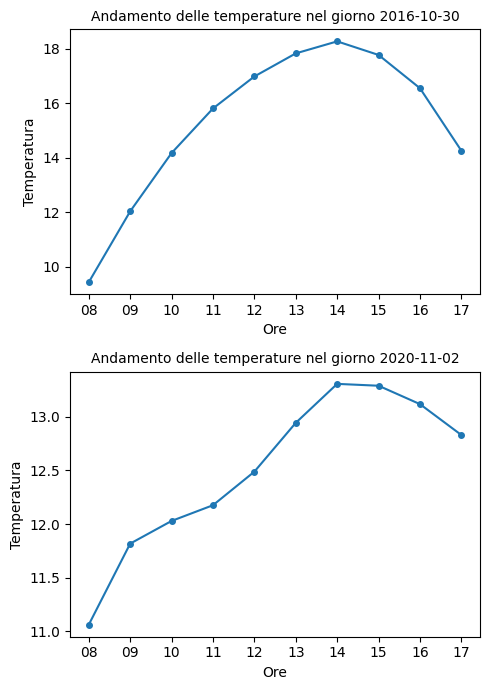

In [ ]:
fig, ax = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(5)
ax[0].set_title('Andamento delle temperature nel giorno {}'.format(day_max_visit[0]), fontsize=10)
ax[0].set(xlabel='Ore', ylabel='Temperatura')
ax[0].plot(time_temp_max, temp_max, 'o', ls='-', ms=4)



ax[1].set_title('Andamento delle temperature nel giorno {}'.format(day_min_visit[0]), fontsize=10)
ax[1].set(xlabel='Ore', ylabel='Temperatura')
ax[1].plot(time_temp_min, temp_min,  'o', ls='-', ms=4 )

fig.tight_layout()
plt.show()


\
***

### **Query 2**
Analizzare la concentrazione di visitatori nei vari POI in un giorno con alte temperature **[ t>20 ]** e con basse temperature **[ t<5 ]**

In [ ]:
m_temp = data_temp.map(lambda x: (x[0], x[2]))\
          .groupByKey()\
          .map(lambda x : (x[0], list(x[1])))\
          .collect()
list_mean_temp=  mean_x(m_temp)
list_mean_temp= sorted(list_mean_temp, key=itemgetter(0))

Ottengo ***list_mean_temp*** così costruita:
```
>> list_mean_temp

[('2014-01-01', 6.722705601907048),
 ('2014-01-02', 4.704927609855206),
 ... ]
```

In [ ]:
# mi salvo in due differenti liste i giorni con alte e basse temperature
list_day_high_temp = []
list_day_low_temp = []
for x in list_mean_temp:
  if(x[1] > 25):
    list_day_high_temp.append(x[0])
  elif (x[1] < 0):
    list_day_low_temp.append(x[0])
  
  

In [ ]:
print("Giorni con alte temperature: {} \n".format(list_day_high_temp))

print("Giorni con basse temperature: {}".format(list_day_low_temp))


Giorni con alte temperature: ['2014-06-10', '2014-06-13', '2014-07-03', '2014-07-17', '2014-07-18', '2014-07-19', '2014-08-04', '2015-06-05', '2015-06-06', '2015-06-07', '2015-06-28', '2015-06-29', '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-11', '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15', '2015-07-17', '2015-07-18', '2015-07-19', '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-26', '2015-07-27', '2015-07-30', '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-12', '2015-08-13', '2015-08-29', '2015-08-30', '2016-06-24', '2016-06-26', '2016-07-01', '2016-07-03', '2016-07-06', '2016-07-07', '2016-07-09', '2016-07-11', '2016-07-18', '2016-07-19', '2016-07-25', '2016-08-08', '2016-08-25', '2016-08-28', '2016-09-02', '2017-06-02', '2017-06-03', '2017-06-07', '2017-06-15', '2017-06-26', '2017-06-27', '2017-07-02', '2017-07-09', '2017-07-12', '2017-07-21', '2017-07-30', '2017-07-31', '2017-08-04', '2017-08-09', '2017-08-20', '201

In [ ]:
# numero di giorni con alte temperature
day_high_temp=len(set(list_day_high_temp))

# numero di giorni con basse temperature
day_low_temp= len(set(list_day_low_temp))

### **Query 2 - Giorni con temperature elevate**

In [ ]:
# seleziono nell'rdd relativa alle VeronaCard, i giorni in cui le temperature erano elevate e creo una lista con elementi: ('POI', numero di visite)
visit_high_temp= data_vr.filter(lambda x: x[0] in list_day_high_temp)\
                .map(lambda x: (x[2], 1))\
                .reduceByKey(lambda a,b: a+b)\
                .sortBy(lambda x: x[0])\
                .collect()


In [ ]:
l_visit =[]
for p in visit_high_temp:
  l_visit.append((p[0], int(p[1]/day_high_temp)))  

list_high_temp = access(poi, l_visit)    
list_high_temp

[144, 131, 100, 76, 12, 0, 13, 0, 0, 3, 39, 31, 29, 82, 0, 52, 29, 105, 0]

### **Query 2 - Giorni con temperature basse**
Eseguo gli stessi passaggi dell'interrogazione con giorni con alte temperature, ma ora considero giorni con basse temperature

In [ ]:
visit_low_temp= data_vr.filter(lambda x: x[0] in list_day_low_temp)\
                  .map(lambda x: (x[2], 1))\
                  .reduceByKey(lambda a,b: a+b)\
                  .sortBy(lambda x: x[0])\
                  .collect()

l_visit=[]
for p in visit_low_temp:
  l_visit.append((p[0], int(p[1]/day_low_temp)))

list_low_temp = access(poi, l_visit)
list_low_temp

[89, 86, 57, 46, 5, 0, 7, 0, 0, 4, 16, 19, 15, 51, 0, 39, 22, 58, 0]

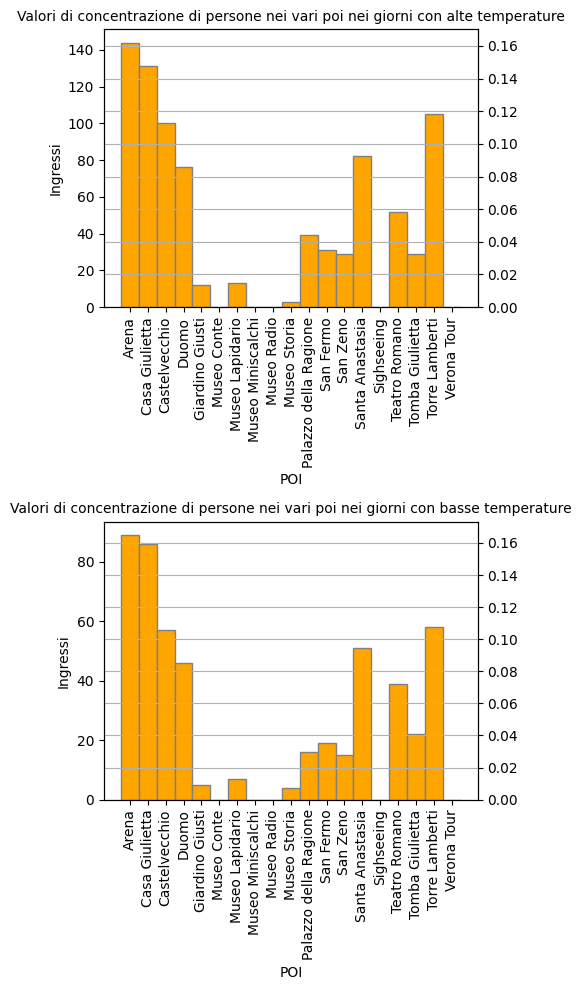

In [ ]:
xs = poi
ys = list_high_temp
l = percent(list_high_temp)

fig, ax = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(5)
ax[0].set_title('Valori di concentrazione di persone nei vari poi nei giorni con alte temperature', fontsize=10)
ax[0].set(xlabel='POI', ylabel='Ingressi')
ax[0].bar(xs, ys,
        1,             # la larghezza delle barre
        ec = "grey",   
                         
        fc = "orange",
        align='center')  # allinea le barre sull'xtick


ax[0].tick_params(axis='x', labelrotation = 90)
ax2= ax[0].twinx()
ax2.set_ylim(min(l), max(l));

plt.grid()
fig.tight_layout()
xs = poi
ys = list_low_temp
l = percent(list_low_temp)

ax[1].set_title('Valori di concentrazione di persone nei vari poi nei giorni con basse temperature', fontsize=10)
ax[1].set(xlabel='POI', ylabel='Ingressi')
ax[1].bar(xs, ys,
        1,             # la larghezza delle barre
        ec = "grey",   
        fc = "orange",
        align='center')  # alline le barre sull'xtick

ax[1].tick_params(axis='x', labelrotation = 90)
ax2= ax[1].twinx()
ax2.set_ylim(min(l), max(l));

fig.tight_layout()
plt.grid()
plt.show()


\
***

# **Previsioni**

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from numpy import array

## **Preparazione dati**

- Funzione ***to_date*** che mi restituisce la data e l'ora da un timestamp  
- Funzione ***to_timestamp*** che mi restituisce il timestamp da un elemento del tipo: ('2021-08-23', '18')
 

In [ ]:
def to_date(timestamp):
    # Converto il timestamp in un oggetto datetime
  dt_from_timestamp = datetime.fromtimestamp(timestamp)
  date= dt_from_timestamp.strftime('%Y-%m-%d %H:%M')
  return date

def to_timestamp(date, time):
  # Converto il timestamp in un oggetto datetime
  dt = datetime.strptime(date + ' ' + time +':00', '%Y-%m-%d %H:%M')
  return dt.timestamp()

### *Temperatura* 

In [ ]:
dt_temp = data_weather.map(lambda x: ((x[0], x[1][:2]), x[2]))\
          .groupByKey()\
          .map(lambda x : (x[0], list(x[1])))\
          .collect()

mean_dt = mean_x(dt_temp)

rdd_mean_temp = sc.parallelize(mean_dt)\
                .sortBy(lambda x: x[0])\
                .map(lambda x: (x[0][0], x[0][1], x[1]))
rdd_mean_temp.persist()
rdd_mean_temp.take(3)

[('2014-01-01', '08', 7.961363636363637),
 ('2014-01-01', '09', 6.312698412698411),
 ('2014-01-01', '10', 6.155000000000002)]

### *Pioggia*

In [ ]:
dt_rain = data_weather.map(lambda x: ((x[0], x[1][:2]), x[3]))\
          .groupByKey()\
          .map(lambda x : (x[0], list(x[1])))\
          .collect()

mean_dr = mean_x(dt_rain)
rdd_mean_rain = sc.parallelize(mean_dr)\
                .sortBy(lambda x: x[0])\
                .map(lambda x: (x[0][0], x[0][1], x[1]))
rdd_mean_rain.persist()
rdd_mean_rain.take(3)

[('2014-01-01', '08', 2.6056818181818184),
 ('2014-01-01', '09', 2.13015873015873),
 ('2014-01-01', '10', 1.7670999999999992)]

\
***

## **Previsione con due classi**

## ***Temperatura***
In questo esempio, abbiamo definito 2 classi di temperatura:
1. basse
2. alte

\
Funzione ***label_data_temp_2*** 

 -  **Input**    
  *point :* ``` ('data', 'ora', valore di temperatura o pioggia) ```     
 - **Output**   
  *LabeledPoint* : ```LabeledPoint(classe, [timestamp, temperatura])``` 




In [ ]:
def label_data_temp_2(point):
    date, time, temp = point
    tm_stamp = to_timestamp(date,time)
    if temp > 10:
        return LabeledPoint(1, [float(tm_stamp), float(temp)])
    else:
        return LabeledPoint(0, [float(tm_stamp), float(temp)])


In [ ]:
labeled_data = rdd_mean_temp.map(lambda x: label_data_temp_2(x))
labeled_data.take(3)

[LabeledPoint(0.0, [1388563200.0,7.961363636363637]),
 LabeledPoint(0.0, [1388566800.0,6.312698412698411]),
 LabeledPoint(0.0, [1388570400.0,6.155000000000002])]

### ***Temperatura - Logistic Regression***


### Training


In [ ]:
train_data, test_data = labeled_data.randomSplit([0.7, 0.3])
model = LogisticRegressionWithLBFGS.train(train_data, iterations=100, numClasses=2)

### Testing

In [ ]:
predictions = model.predict(test_data.map(lambda x: x.features))
label_predict= predictions.collect()

# Calcolo l'accuratezza delle previsioni
label_test_true = test_data.map(lambda x: int(x.label)).collect()
label_test_true = [int(x) for x in label_test_true]
accuracy = sum([ int(x==y) for x, y in zip(label_predict, label_test_true)]) / len(label_predict)
print(accuracy)

0.9786655211912944


In [ ]:
test_features= test_data.map(lambda x: (array([datetime.strptime(to_date(x.features[0]),'%Y-%m-%d %H:%M')\
                                               .date(),x.features[1]]), int(x.label)))\
                                               .collect()
train_features= train_data.map(lambda x: (array([datetime.strptime(to_date(x.features[0]),'%Y-%m-%d %H:%M')\
                                                 .date(),x.features[1]]), int(x.label)))\
                                                 .collect()

### ***Temperatura - Plot***

In [ ]:
# divido i dati di test in base alle due classi
test_class1=[]
test_class2=[]
for i in range(len(test_features)):
  if(label_predict[i] == 0):
    test_class1.append(test_features[i])
  else:
    test_class2.append(test_features[i])



In [ ]:
import matplotlib.pyplot as plt

train_x_1 = [x[0][0] for x in train_features]
train_y_1  = [x[0][1] for x in train_features]
test_x1_1  = [x[0][0] for x in test_class1]
test_y1_1  = [x[0][1] for x in test_class1]
test_x2_1  = [x[0][0] for x in test_class2]
test_y2_1  = [x[0][1] for x in test_class2]


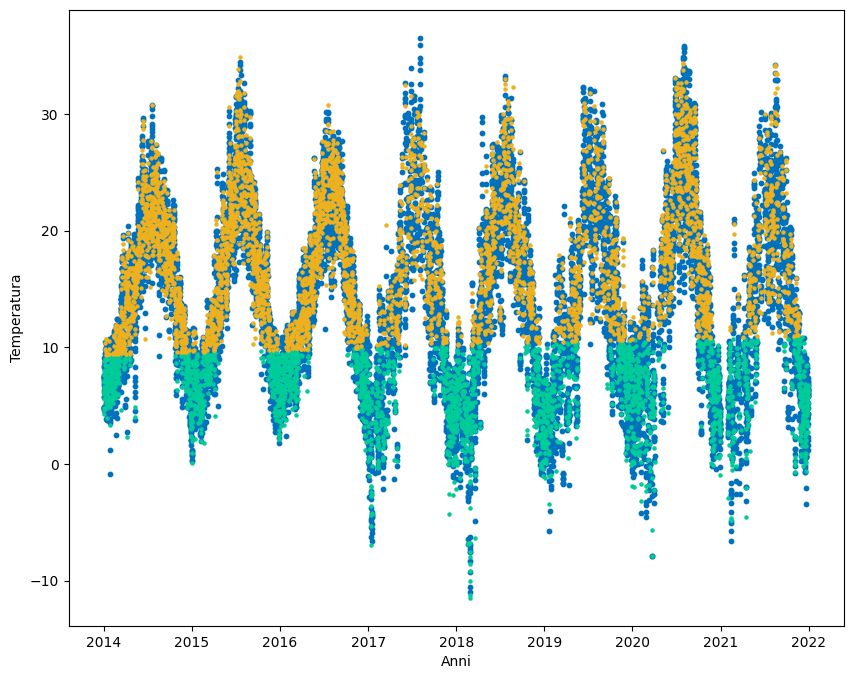

In [ ]:
import matplotlib.dates as md
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
ax.scatter(train_x_1 , train_y_1 , c='#0072BD', s=10)
ax.scatter(test_x1_1 , test_y1_1 , c= '#00CC99', s=5)
ax.scatter(test_x2_1 , test_y2_1 , c= '#EDB120', s=5)
plt.xlabel("Anni")
plt.ylabel("Temperatura")
plt.show()

## ***Pioggia***
In questo esempio andiamo a definire due classi di pioggia: 

1. Pioggia leggera/media
2. Pioggia forte

\
Funzione ***label_data_rain_2*** 

 -  **Input**    
  *point :* ``` ('data', 'ora', valore di pioggia) ```     
 - **Output**   
  *LabeledPoint* : ```LabeledPoint(classe, [timestamp, pioggia])``` 


In [ ]:
def label_data_rain_2(point):
    date, time, rain = point
    tm_stamp = to_timestamp(date,time)
    if rain > 6:
        return LabeledPoint(1, [float(tm_stamp), float(rain)])
    else:
        return LabeledPoint(0, [float(tm_stamp), float(rain)])

In [ ]:
labeled_data = rdd_mean_rain.map(lambda x: label_data_rain_2(x))
labeled_data.take(3)

[LabeledPoint(0.0, [1388563200.0,2.6056818181818184]),
 LabeledPoint(0.0, [1388566800.0,2.13015873015873]),
 LabeledPoint(0.0, [1388570400.0,1.7670999999999992])]

### ***Pioggia - Logistic Regression***

### Training


In [ ]:
training_data, test_data = labeled_data.randomSplit([0.7, 0.3])
model = LogisticRegressionWithLBFGS.train(training_data, iterations=100, numClasses=2)

### Testing

In [ ]:
predictions = model.predict(test_data.map(lambda x: x.features))
label_predict= predictions.collect()

# Calcolo l'accuratezza delle previsioni
label_test_true = test_data.map(lambda x: int(x.label)).collect()
label_test_true = [int(x) for x in label_test_true]
accuracy = sum([ int(x==y) for x, y in zip(label_predict, label_test_true)]) / len(label_predict)

print(accuracy)

0.9896262611908484


In [ ]:
test_features= test_data.map(lambda x: (array([datetime.strptime(to_date(x.features[0]),'%Y-%m-%d %H:%M')\
                                               .date(),x.features[1]]), int(x.label)))\
                                               .collect()
train_features= training_data.map(lambda x: (array([datetime.strptime(to_date(x.features[0]),'%Y-%m-%d %H:%M')\
                                                    .date(),x.features[1]]), int(x.label)))\
                                                    .collect()

### ***Pioggia - Plot***

In [ ]:
# divido i dati di test in base alle due classi
test_class1=[]
test_class2=[]
for i in range(len(test_features)):
  if(label_predict[i] == 0):
    test_class1.append(test_features[i])
  else:
    test_class2.append(test_features[i])



In [ ]:
import matplotlib.pyplot as plt

train_x_2 = [x[0][0] for x in train_features]
train_y_2 = [x[0][1] for x in train_features]
test_x1_2 = [x[0][0] for x in test_class1]
test_y1_2 = [x[0][1] for x in test_class1]
test_x2_2 = [x[0][0] for x in test_class2]
test_y2_2 = [x[0][1] for x in test_class2]


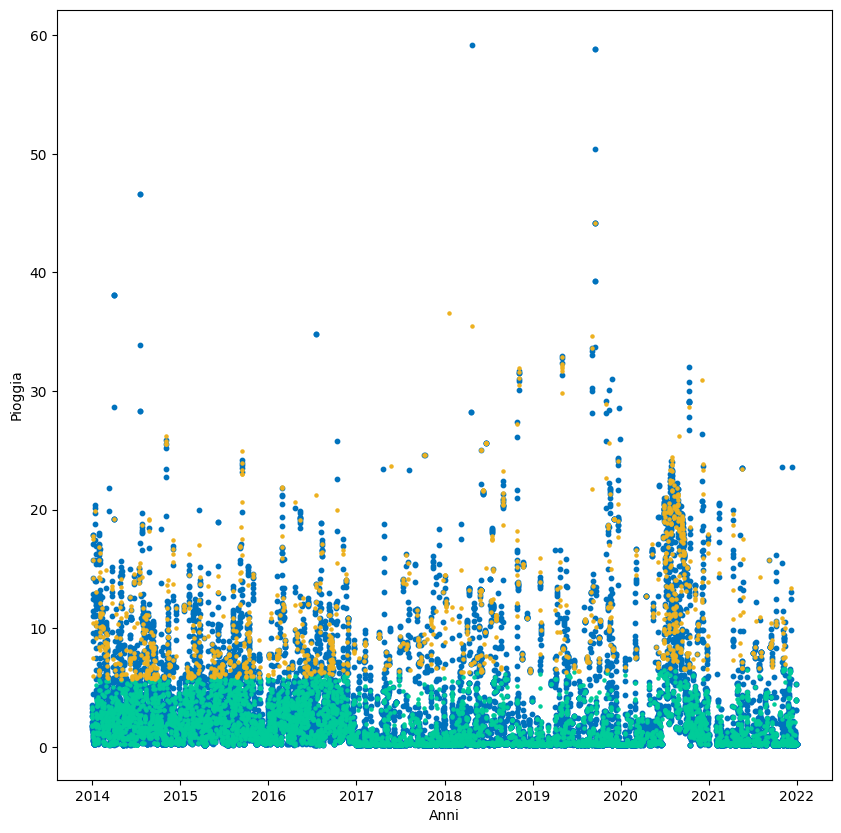

In [ ]:
# Per ingrandire il plot, scommentare le parti commentate e commentare la seconda riga

fig, ax = plt.subplots()
fig.set_figheight(10)
#fig.set_figheight(30)
fig.set_figwidth(10)
ax.scatter(train_x_2, train_y_2, c='#0072BD', s=10)
ax.scatter(test_x1_2, test_y1_2, c= '#00CC99', s=5)
ax.scatter(test_x2_2, test_y2_2, c= '#EDB120', s=5)
#plt.axhline(y=6, color='red')
plt.xlabel("Anni")
plt.ylabel("Pioggia")
plt.show()

\
***

## *Classificazione con più di 2 classi*

## **Temperatura**
In questo esempio, abbiamo definito 4 classi di temperatura:
1. sotto zero
2. basse
3. medie 
4. alte

\
Funzione ***label_data_temp_4*** 

 -  **Input**    
  *point :* ``` ('data', 'ora', valore di temperatura) ```     
 - **Output**   
  *LabeledPoint* : ```LabeledPoint(classe, [timestamp, temperatura])``` 

In [ ]:
def label_data_temp_4(point):
  date, time, temp = point
  if temp < 0:
    label = 0 # Temperatura sotto zero
  elif temp < 10:
    label = 1 # Temperatura bassa
  elif temp < 20:
    label = 2 # Temperatura media
  else:
    label = 3 # Temperatura alta

  tm_stamp = to_timestamp(date, time)

  return LabeledPoint(label, [float(tm_stamp), float(temp)])

In [ ]:
labeled_data = rdd_mean_temp.map(lambda x: label_data_temp_4(x))

## **Training**

In [ ]:
train_data, test_data = labeled_data.randomSplit([0.7, 0.3])
model = LogisticRegressionWithLBFGS.train(train_data, numClasses=4)

## **Testing**

In [ ]:
predictions = model.predict(test_data.map(lambda x: x.features))

# Calcolo l'accuratezza delle previsioni
label_test_true = test_data.map(lambda x: int(x.label)).collect()
label_predict = predictions.collect()
accuracy = sum([int(x == y) for x, y in zip(label_predict, label_test_true)]) / len(label_predict)

print(accuracy)

0.9454938716654651


In [ ]:
test_features= test_data.map(lambda x: (array([datetime.strptime(to_date(x.features[0]),'%Y-%m-%d %H:%M')\
                                               .date(),x.features[1]]), int(x.label)))\
                                               .collect()
train_features= train_data.map(lambda x: (array([datetime.strptime(to_date(x.features[0]),'%Y-%m-%d %H:%M')\
                                                 .date(),x.features[1]]), int(x.label)))\
                                                 .collect()

### Plot

In [ ]:
test_class0=[]
test_class1=[]
test_class2=[]
test_class3=[]
for i in range(len(test_features)):
  if(label_predict[i] == 0):
    test_class0.append(test_features[i])
  elif label_predict[i] == 1:
    test_class1.append(test_features[i])
  elif label_predict[i] == 2:
    test_class2.append(test_features[i])
  else:
    test_class3.append(test_features[i])


In [ ]:
import matplotlib.pyplot as plt

train_x_3 = [x[0][0] for x in train_features]
train_y_3 = [x[0][1] for x in train_features]
test_x0_3 = [x[0][0] for x in test_class0]
test_y0_3 = [x[0][1] for x in test_class0]
test_x1_3 = [x[0][0] for x in test_class1]
test_y1_3 = [x[0][1] for x in test_class1]
test_x2_3 = [x[0][0] for x in test_class2]
test_y2_3 = [x[0][1] for x in test_class2]
test_x3_3 = [x[0][0] for x in test_class3]
test_y3_3 = [x[0][1] for x in test_class3]

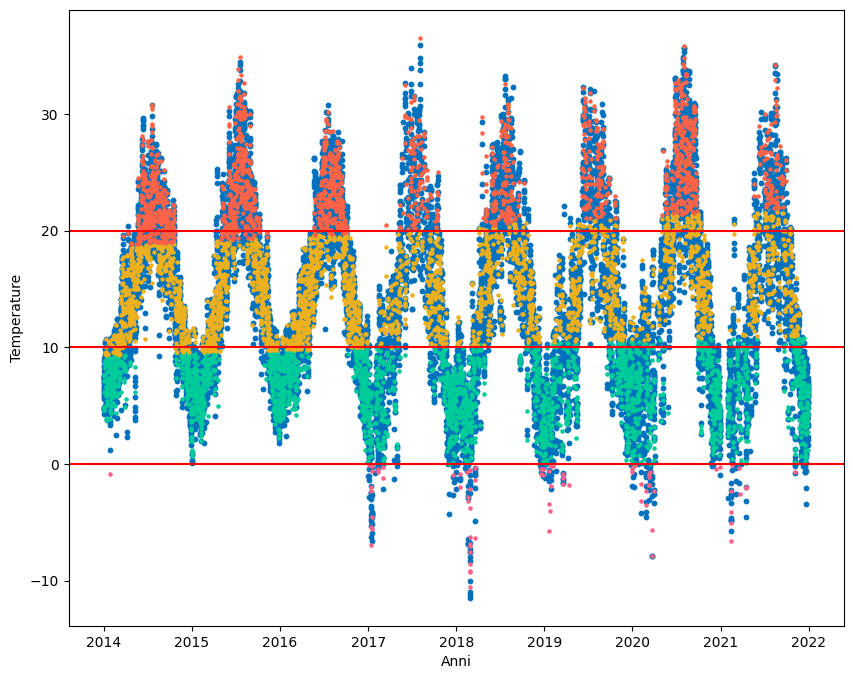

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
ax.scatter(train_x_3, train_y_3, c='#0072BD', s=10)
ax.scatter(test_x0_3, test_y0_3, c= '#FF6088', s=5)
ax.scatter(test_x1_3, test_y1_3, c= '#00CC99', s=5)
ax.scatter(test_x2_3, test_y2_3, c= '#EDB120', s=5)
ax.scatter(test_x3_3, test_y3_3, c= '#FF6347', s=5)
plt.axhline(y=0, color='red')
plt.axhline(y=10, color='red')
plt.axhline(y=20, color='red')
plt.xlabel("Anni")
plt.ylabel("Temperature")
plt.show()

## **Pioggia**
In questo esempio, abbiamo definito 5 classi di livelli di pioggia:
1. debole
2. leggera
3. moderata 
4. forte
5. nubifragio

\
Funzione ***label_data_rain_5*** 

 -  **Input**    
  *point :* ``` ('data', 'ora', valore di pioggia) ```     
 - **Output**   
  *LabeledPoint* : ```LabeledPoint(classe, [timestamp, pioggia])``` 

In [ ]:
def label_data_rain_5(point):
  date, time, rain = point
  if rain < 2:
    label = 0 # Pioggia debole
  elif rain < 4:
    label = 1 # Pioggia leggera
  elif rain < 6:
    label = 2 # Pioggia moderata
  elif rain < 10:
    label = 3 # Pioggia forte
  else:
    label = 4 # Rovescio

  tm_stamp = to_timestamp(date, time)

  return LabeledPoint(label, [float(tm_stamp), float(rain)])

In [ ]:
labeled_data = rdd_mean_rain.map(lambda x: label_data_rain_5(x))

## **Training**

In [ ]:
train_data, test_data = labeled_data.randomSplit([0.7, 0.3])
model = LogisticRegressionWithLBFGS.train(train_data, numClasses=5)

## **Testing**

In [ ]:
predictions = model.predict(test_data.map(lambda x: x.features))
label_test_true = test_data.map(lambda x: int(x.label)).collect()
label_predict = predictions.collect()
accuracy = sum([int(x == y) for x, y in zip(label_predict, label_test_true)]) / len(label_predict)

print(accuracy)

0.9615877080665813


In [ ]:
test_features= test_data.map(lambda x: (array([datetime.strptime(to_date(x.features[0]),'%Y-%m-%d %H:%M')\
                                               .date(),x.features[1]]), int(x.label)))\
                                               .collect()
train_features= train_data.map(lambda x: (array([datetime.strptime(to_date(x.features[0]),'%Y-%m-%d %H:%M')\
                                                 .date(),x.features[1]]), int(x.label)))\
                                                 .collect()

### Plot

In [ ]:
test_class0=[]
test_class1=[]
test_class2=[]
test_class3=[]
test_class4=[]
for i in range(len(test_features)):
  if(label_predict[i] == 0):
    test_class0.append(test_features[i])
  elif label_predict[i] == 1:
    test_class1.append(test_features[i])
  elif label_predict[i] == 2:
    test_class2.append(test_features[i])
  elif label_predict[i] == 3:
    test_class3.append(test_features[i])
  else:
    test_class4.append(test_features[i])


In [ ]:
# Plot clusters and data points
import matplotlib.pyplot as plt

train_x_4 = [x[0][0] for x in train_features]
train_y_4 = [x[0][1] for x in train_features]
test_x0_4 = [x[0][0] for x in test_class0]
test_y0_4 = [x[0][1] for x in test_class0]
test_x1_4 = [x[0][0] for x in test_class1]
test_y1_4 = [x[0][1] for x in test_class1]
test_x2_4 = [x[0][0] for x in test_class2]
test_y2_4 = [x[0][1] for x in test_class2]
test_x3_4 = [x[0][0] for x in test_class3]
test_y3_4 = [x[0][1] for x in test_class3]
test_x4_4 = [x[0][0] for x in test_class4]
test_y4_4 = [x[0][1] for x in test_class4]

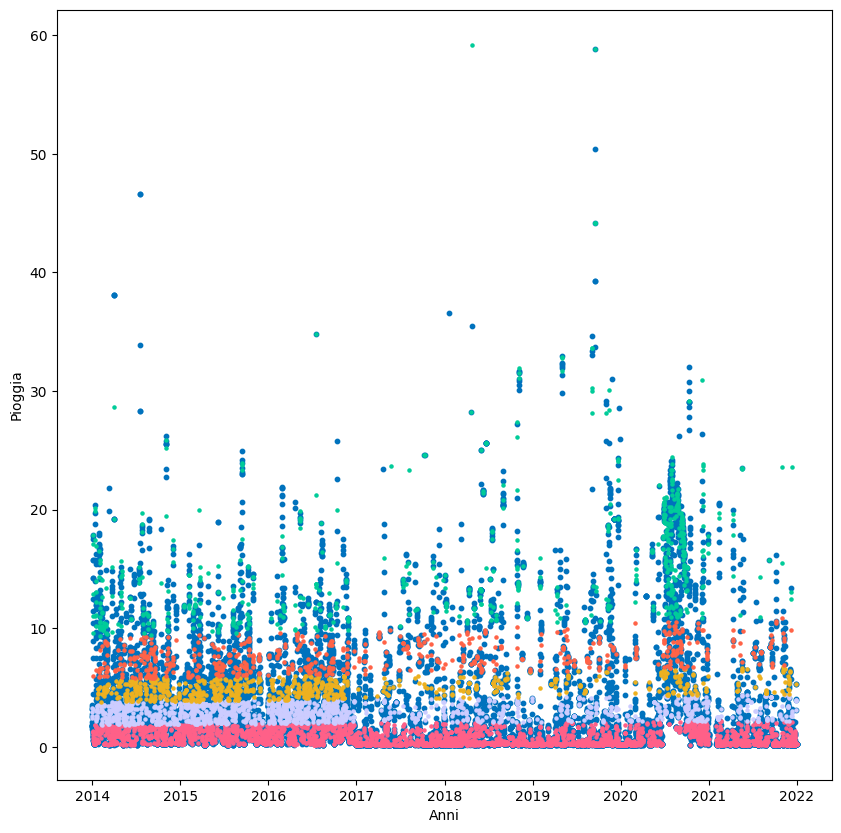

In [ ]:
# Per ingrandire il plot, scommentare le parti commentate e commentare la seconda riga
fig, ax = plt.subplots()
fig.set_figheight(10)
#fig.set_figheight(30)
fig.set_figwidth(10)
ax.scatter(train_x_4, train_y_4, c='#0072BD', s=10)
ax.scatter(test_x0_4, test_y0_4, c= '#FF6088', s=5)
ax.scatter(test_x1_4, test_y1_4, c= '#CCCCFF', s=5)
ax.scatter(test_x2_4, test_y2_4, c= '#EDB120', s=5)
ax.scatter(test_x3_4, test_y3_4, c= '#FF6347', s=5)
ax.scatter(test_x4_4, test_y4_4, c= '#00CC99', s=5)
#plt.axhline(y=2, color='red')
#plt.axhline(y=4, color='red')
#plt.axhline(y=6, color='red')
#plt.axhline(y=10, color='red')
plt.xlabel("Anni")
plt.ylabel("Pioggia")
plt.show()